<a href="https://colab.research.google.com/github/Hanh42/AI---UEH-K50/blob/main/Body_fat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Import các thư viện cần thiết
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt  # Cho vẽ biểu đồ

In [ ]:
# Cell 2: Tải dữ liệu Body Fat (từ TinyURL)
url = "https://tinyurl.com/yd7etaf8"
columns = [
    'Density', 'Age', 'Weight', 'Height', 'Adiposity', 'Neck', 'Chest',
    'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm',
    'Wrist', 'BodyFat'
]

# Đọc dữ liệu
df = pd.read_csv(url, names=columns)

# Hiển thị 5 dòng đầu tiên
print("5 dòng đầu tiên của dữ liệu:")
print(df.head())


5 dòng đầu tiên của dữ liệu:
   Density      Age Weight  Height Adiposity   Neck Chest Abdomen      Hip  \
0  Subject  Bodyfat    Age  Weight    Height    FFW  Neck   Chest  Abdomen   
1        1     21.1     54   151.5     70.75  119.6  35.6      90     83.9   
2        2     24.2     46   192.5     71.75  145.9    38   106.6     97.5   
3        3      9.9     23  159.75     72.25  143.9  35.5    92.1     77.1   
4        4     14.9     55   169.5     68.25  144.2  37.2   101.7     91.1   

   Thigh   Knee Ankle Biceps Forearm    Wrist BodyFat  
0    Hip  Thigh  Knee  Ankle   Bicep  Forearm   Wrist  
1   93.9     55  36.1   21.7    29.6     16.4    16.9  
2  100.6   58.9  40.5   24.5    33.3     18.8      19  
3   93.9   56.1  36.1   22.7    30.5     18.5    18.3  
4   97.1   56.6  38.5   22.6    33.4     17.6    18.2  


In [ ]:
# Cell 3: Xử lý dữ liệu trước khi train (chạy sau Cell 2)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- Nếu df chưa được load (chạy Cell 3 độc lập), fallback tải từ URL ---
columns = [
    'Density', 'Age', 'Weight', 'Height', 'Adiposity', 'Neck', 'Chest',
    'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm',
    'Wrist', 'BodyFat'
]
if 'df' not in globals():
    url = "https://tinyurl.com/yd7etaf8"
    df = pd.read_csv(url, names=columns)
    print("df chưa tồn tại — đã tải từ URL.")

print("Raw rows:", len(df))
# Nếu bạn vẫn muốn xem EDA, chạy cell khám phá (df.info/describe) trước khi tiến hành cell này.

# Xóa hàng hoàn toàn rỗng
df = df.dropna(how='all')

# Loại bỏ cột ID nếu có
if 'Subject' in df.columns:
    df = df.drop(columns=['Subject'])

# Chuẩn hóa tên cột target nếu khác tên
if 'BodyFat' not in df.columns:
    alt = [c for c in df.columns if 'body' in c.lower() and 'fat' in c.lower()]
    if len(alt) > 0:
        df = df.rename(columns={alt[0]:'BodyFat'})

# Ép kiểu số cho tất cả cột, lỗi -> NaN
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Bỏ hàng không có target
df = df.dropna(subset=['BodyFat'])
print("Rows after dropping missing BodyFat:", len(df))

# (Tùy chọn) giữ/drop 'Density' — ở đây giữ lại, nếu bạn muốn loại bỏ thì uncomment:
# if 'Density' in df.columns:
#     df = df.drop(columns=['Density'])

# Loại outlier bằng IQR trên các cột số (an toàn, không dùng thư viện ngoài)
numeric = df.select_dtypes(include=[np.number])
Q1 = numeric.quantile(0.25)
Q3 = numeric.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
mask = ((numeric >= lower) & (numeric <= upper)).all(axis=1)
df_clean = df[mask].copy()
print("Rows after IQR outlier removal:", len(df_clean))

# Nếu IQR loại quá nhiều (ví dụ <50% or <10 rows), fallback không loại outlier
if len(df_clean) < max(10, int(0.5 * len(df))):
    print("IQR removed too many rows -> sử dụng df gốc (không loại outlier).")
    df_clean = df.copy()

# Feature engineering đơn giản (tỉ lệ Weight/Height và Weight/Height^2 nếu có)
if ('Weight' in df_clean.columns) and ('Height' in df_clean.columns):
    h = df_clean['Height'].replace(0, np.nan).fillna(df_clean['Height'].median())
    df_clean['W_div_H'] = df_clean['Weight'] / h
    df_clean['W_div_H2'] = df_clean['Weight'] / (h ** 2)

# Chuẩn bị X, y
X = df_clean.drop(columns=['BodyFat'])
y = df_clean['BodyFat']

# Điền NaN còn lại (theo median) và ép kiểu
X = X.fillna(X.median())
X = X.apply(pd.to_numeric, errors='coerce').fillna(0.0)

# Scale và ép dtype cho tensorflow
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)
y_arr = y.to_numpy(dtype=np.float32)

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_arr, test_size=0.2, random_state=42
)

print("Final shapes -> X_train:", X_train.shape, "X_test:", X_test.shape)


Raw rows: 201
Rows after dropping missing BodyFat: 200
Rows after IQR outlier removal: 186
Final shapes -> X_train: (148, 17) X_test: (38, 17)


In [ ]:
# Cell EXPERIMENT: thử nhiều chiến lược để tăng R² (đặt sau Cell 3 — sau khi df đã được load)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
tf.random.set_seed(42)

def build_model_exp(input_dim, lr=1e-3):
    # model nhẹ dùng lại các lớp đã cho (không import thêm)
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,),
              kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        Dropout(0.2),
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        Dropout(0.1),
        Dense(1)
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

def r2_score_np(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    if ss_tot == 0:
        return np.nan
    return 1.0 - ss_res / ss_tot

def train_and_evaluate_exp(X_df, y_ser, exp_name, epochs=200, batch_size=16):
    # conver to numeric, fillna, scale, split, train (using names with _exp to not collide)
    X_num = X_df.apply(pd.to_numeric, errors='coerce').fillna(X_df.median())
    y_num = pd.to_numeric(y_ser, errors='coerce').fillna(y_ser.mean())

    scaler_exp = StandardScaler()
    X_scaled = scaler_exp.fit_transform(X_num).astype(np.float32)
    y_arr = y_num.to_numpy(dtype=np.float32)

    Xtr, Xte, ytr, yte = train_test_split(X_scaled, y_arr, test_size=0.2, random_state=42)

    model_exp = build_model_exp(Xtr.shape[1], lr=1e-3)
    # train
    history = model_exp.fit(Xtr, ytr, validation_data=(Xte, yte),
                            epochs=epochs, batch_size=batch_size, verbose=0)
    ypred = model_exp.predict(Xte).reshape(-1)
    r2 = r2_score_np(yte, ypred)
    print(f"[{exp_name}] rows={X_df.shape[0]:d}, features={X_df.shape[1]:d} => R2 = {r2:.4f} ({r2*100:.2f}%)")
    return {'name': exp_name, 'r2': r2, 'model': model_exp, 'scaler': scaler_exp, 'history': history}

# --- 1) chuẩn hóa dữ liệu gốc (chỉ numeric) ---
df_exp = df.copy()   # không sửa df gốc
# loại bỏ cột Subject nếu có
if 'Subject' in df_exp.columns:
    df_exp = df_exp.drop(columns=['Subject'])
# ép số, loại hàng target rỗng
df_exp = df_exp.apply(pd.to_numeric, errors='coerce')
df_exp = df_exp.dropna(subset=['BodyFat']).fillna(df_exp.median())

print("Original loaded rows:", len(df), " after basic numeric coercion:", len(df_exp))

# --- 2) loại outlier bằng z-score (tùy chọn) ---
numeric = df_exp.select_dtypes(include=[np.number])
z = (numeric - numeric.mean()) / (numeric.std(ddof=0) + 1e-12)
mask_keep = (np.abs(z) <= 3).all(axis=1)   # giữ những dòng có tất cả giá trị |z| <= 3
df_clean_exp = df_exp[mask_keep].copy()
print("After z-score (|z|<=3) cleaning rows:", len(df_clean_exp))

# --- 3) chuẩn bị 3 bộ features để thử ---
X_base_exp = df_clean_exp.drop(columns=['BodyFat'])
y_base_exp = df_clean_exp['BodyFat']

# (A) as-is (sau clean)
dsA = ('clean_as_is', X_base_exp, y_base_exp)

# (B) drop 'Density' nếu tồn tại (một số dataset có Density liên quan trực tiếp tới BodyFat)
X_no_density = X_base_exp.drop(columns=['Density'], errors='ignore')
dsB = ('drop_density', X_no_density, y_base_exp)

# (C) thêm biến phi tuyến: bình phương từng đặc trưng + tỉ lệ Weight/Height nếu có
X_poly = X_base_exp.copy()
for c in list(X_base_exp.columns):
    X_poly[c + '_sq'] = X_base_exp[c].astype(float) ** 2

# thêm tỉ lệ Weight/Height và Weight/(Height^2) nếu có cột tương ứng
if ('Weight' in X_base_exp.columns) and ('Height' in X_base_exp.columns):
    # tránh chia cho 0
    h = X_base_exp['Height'].replace(0, np.nan).fillna(X_base_exp['Height'].median())
    X_poly['W_div_H'] = X_base_exp['Weight'] / h
    X_poly['W_div_H2'] = X_base_exp['Weight'] / (h**2)

dsC = ('poly_plus_ratio', X_poly, y_base_exp)

datasets = [dsA, dsB, dsC]

# --- 4) chạy thử cho từng dataset (mỗi lần train độc lập, đặt tên biến riêng) ---
results_exp = []
for name, Xdf, yser in datasets:
    if Xdf.shape[0] < 10 or Xdf.shape[1] < 1:
        print(f"Skipping {name}: not enough data/features.")
        continue
    res = train_and_evaluate_exp(Xdf, yser, exp_name=name, epochs=200, batch_size=16)
    results_exp.append(res)

# --- 5) In bảng kết quả sắp xếp theo R2 giảm dần ---
results_exp_sorted = sorted(results_exp, key=lambda r: r['r2'], reverse=True)
print("\n=== SUMMARY (sorted by R2) ===")
for r in results_exp_sorted:
    print(f"{r['name']:20s} -> R2 = {r['r2']:.4f} ({r['r2']*100:.2f}%)")


Original loaded rows: 200  after basic numeric coercion: 200
After z-score (|z|<=3) cleaning rows: 195


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[clean_as_is] rows=195, features=15 => R2 = 0.2661 (26.61%)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[drop_density] rows=195, features=14 => R2 = 0.4632 (46.32%)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[poly_plus_ratio] rows=195, features=32 => R2 = -0.0734 (-7.34%)

=== SUMMARY (sorted by R2) ===
drop_density         -> R2 = 0.4632 (46.32%)
clean_as_is          -> R2 = 0.2661 (26.61%)
poly_plus_ratio      -> R2 = -0.0734 (-7.34%)


In [70]:
# Cell 4: Xử lý dữ liệu toàn diện với outlier removal + feature engineering

# 1) Bỏ cột không cần
if 'Subject' in df.columns:
    df = df.drop(columns=['Subject'])

# 2) Tạo feature BMI và các biến phi tuyến khác
if 'Weight' in df.columns and 'Height' in df.columns:
    h = df['Height'].replace(0, np.nan).fillna(df['Height'].median())
    df['BMI'] = df['Weight'] / (h ** 2)
    df['BMI_sq'] = df['BMI'] ** 2
    df['Weight_div_Height'] = df['Weight'] / h

# 3) Ép số, xử lý NaN
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=['BodyFat']).fillna(df.median())

# 4) Loại outlier bằng Z-score
numeric = df.select_dtypes(include=[np.number])
z = (numeric - numeric.mean()) / (numeric.std(ddof=0) + 1e-12)
mask = (abs(z) <= 3).all(axis=1)
df = df[mask].copy()

# 5) Tách X, y
X = df.drop(columns=['BodyFat'])
y = df['BodyFat']

# 6) Chuẩn hóa
scaler = StandardScaler()
X = scaler.fit_transform(X).astype(np.float32)
y = y.to_numpy(dtype=np.float32)

# 7) Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (149, 18) Test: (38, 18)


In [71]:
# Cell 5: Mô hình MLP cân bằng
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],),
          kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    Dropout(0.1),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_81 (Dense)                │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,801 (50.00 KB)

 Trainable params: 12,801 (50.00 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
# Cell 6: Huấn luyện mạnh tay
history = model.fit(
    X_train.astype(np.float32), y_train.astype(np.float32),
    validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)),
    epochs=600,
    batch_size=8,    # batch nhỏ để học chi tiết hơn
    verbose=1
)


Epoch 1/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.3926 - mae: 0.5038 - val_loss: 0.5894 - val_mae: 0.6850
Epoch 2/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3354 - mae: 0.4486 - val_loss: 0.1920 - val_mae: 0.3530
Epoch 3/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3239 - mae: 0.4509 - val_loss: 0.3808 - val_mae: 0.5468
Epoch 4/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2768 - mae: 0.3745 - val_loss: 0.7327 - val_mae: 0.7890
Epoch 5/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1945 - mae: 0.3383 - val_loss: 0.7161 - val_mae: 0.7437
Epoch 6/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2286 - mae: 0.3700 - val_loss: 0.5290 - val_mae: 0.6076
Epoch 7/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2262 - mae: 0.3672 - val_loss: 0.5679 - val_mae: 0.6616
Epoch 8/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3642 - mae: 0.4337 - val_loss: 0.5146 - val_mae: 0.6363
Epoch 9/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.29

In [77]:
# Cell X: Đánh giá mô hình với R² Score
from sklearn.metrics import r2_score

# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Tính R²
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f} ({r2*100:.2f}%)")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
R² Score: 0.8483 (84.83%)


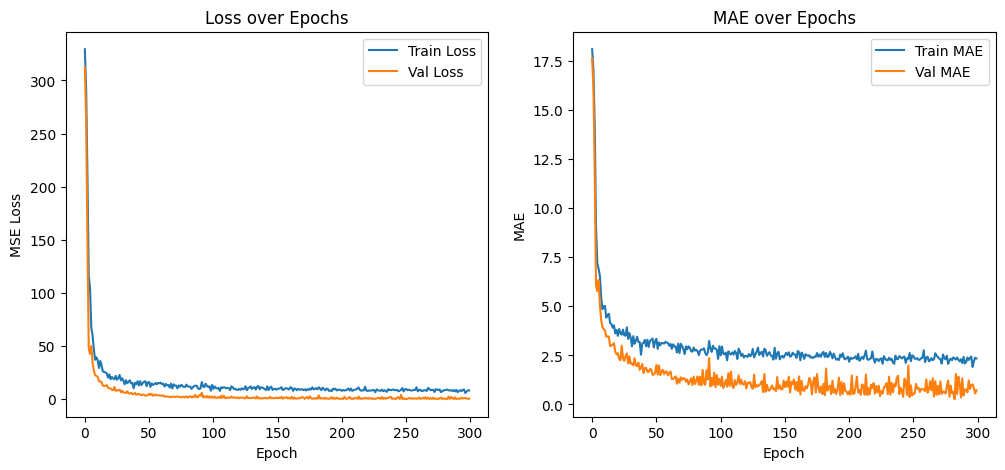

In [ ]:
# Cell 8: Vẽ biểu đồ loss và MAE
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [81]:
# Cell 11: Import thư viện và khai báo tên features
import gradio as gr
import numpy as np

# Danh sách các đặc trưng (feature)
feature_names = [
    'Density', 'Age', 'Weight', 'Height', 'Adiposity', 'Neck', 'Chest',
    'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist'
]


In [82]:
# Cell 12: Hàm dự đoán Body Fat
def predict_bodyfat_gradio(*values):
    features = np.array(values).reshape(1, -1)
    features = scaler.transform(features)
    prediction = model.predict(features)
    return f"🔮 Dự đoán Body Fat: {prediction[0][0]:.2f}%"


In [85]:
# Cell 13: Tạo input tiếng Việt với đơn vị rõ ràng
inputs = []

labels_vi = [
    "Mật độ (g/cm³)", "Tuổi (năm)", "Cân nặng (lbs)", "Chiều cao (inch)",
    "Tỷ lệ mỡ (Adiposity)", "Vòng cổ (cm)", "Vòng ngực (cm)",
    "Vòng bụng (cm)", "Vòng hông (cm)", "Vòng đùi (cm)",
    "Vòng gối (cm)", "Vòng cổ chân (cm)", "Vòng bắp tay (cm)",
    "Vòng cẳng tay (cm)", "Vòng cổ tay (cm)"
]

for label in labels_vi:
    inputs.append(gr.Number(label=label, precision=None))


In [94]:
# Cell 15: Hàm dự đoán an toàn — thay thế predict_bodyfat_gradio
import numpy as np
import pandas as pd

# Danh sách base features theo thứ tự app đang gửi (15 giá trị)
_base_features = ['Density','Age','Weight','Height','Adiposity',
                  'Neck','Chest','Abdomen','Hip','Thigh','Knee','Ankle','Biceps','Forearm','Wrist']

def _safe_predict(*vals):
    try:
        # 1) Kiểm tra số lượng giá trị
        if len(vals) != len(_base_features):
            return f"Lỗi: cần {len(_base_features)} giá trị nhưng nhận {len(vals)}."

        # 2) Tạo dict base, thay None bằng median từ df nếu có
        base = {}
        for name, val in zip(_base_features, vals):
            if val is None or (isinstance(val, float) and np.isnan(val)):
                if 'df' in globals() and name in df.columns:
                    base[name] = float(df[name].median())
                else:
                    base[name] = 0.0
            else:
                base[name] = float(val)

        row = pd.DataFrame([base])

        # 3) Tạo các feature engineering giống pipeline training (BMI,..)
        if 'Weight' in row.columns and 'Height' in row.columns:
            h = float(row.at[0,'Height'])
            if h == 0:
                # fallback median nếu có
                if 'df' in globals() and 'Height' in df.columns:
                    h = float(df['Height'].median())
                else:
                    h = 1.0
            row['BMI'] = row['Weight'] / (h ** 2)
            row['BMI_sq'] = row['BMI'] ** 2
            row['Weight_div_Height'] = row['Weight'] / h

        # 4) Xác định expected columns theo scaler hoặc df
        if hasattr(scaler, 'feature_names_in_'):
            expected_cols = list(scaler.feature_names_in_)
        elif 'df' in globals():
            expected_cols = [c for c in df.columns if c != 'BodyFat']
        else:
            expected_cols = list(row.columns)

        # 5) Tạo _sq cho các cột nếu expected cần
        for col in list(row.columns):
            sq = f"{col}_sq"
            if sq in expected_cols and sq not in row.columns:
                row[sq] = row[col] ** 2

        # 6) Tạo các interaction nếu expected chứa "_x_"
        inter_cols = [c for c in expected_cols if '_x_' in c]
        for inter in inter_cols:
            a,b = inter.split('_x_')
            va = row[a].iloc[0] if a in row.columns else (float(df[a].median()) if ('df' in globals() and a in df.columns) else 0.0)
            vb = row[b].iloc[0] if b in row.columns else (float(df[b].median()) if ('df' in globals() and b in df.columns) else 0.0)
            row[inter] = va * vb

        # 7) Tạo final row theo đúng order expected_cols
        final_vals = []
        for c in expected_cols:
            if c in row.columns:
                final_vals.append(row[c].iloc[0])
            else:
                # cố gắng lấp bằng median từ df nếu có, hoặc 0
                if 'df' in globals() and c in df.columns:
                    final_vals.append(float(df[c].median()))
                elif c.endswith('_sq'):
                    basec = c[:-3]
                    if basec in row.columns:
                        final_vals.append(float(row[basec].iloc[0]) ** 2)
                    else:
                        final_vals.append(0.0)
                else:
                    final_vals.append(0.0)

        X_row = np.array([final_vals], dtype=np.float32)

        # 8) Scale và predict
        X_scaled = scaler.transform(X_row)
        pred = model.predict(X_scaled).reshape(-1)[0]
        return f"{pred:.2f} %"

    except Exception as e:
        # trả lỗi rõ ràng để debug
        return f"Lỗi khi dự đoán: {type(e).__name__}: {str(e)}"

# Gán lại tên hàm mà UI dùng
predict_bodyfat_gradio = _safe_predict

print("Hàm dự đoán an toàn đã được cập nhật. Hãy dừng app hiện tại (nếu có) và chạy lại Cell 14 để áp dụng.")


Hàm dự đoán an toàn đã được cập nhật. Hãy dừng app hiện tại (nếu có) và chạy lại Cell 14 để áp dụng.


In [98]:
# Cell 14: App giao diện tiếng Việt với label trắng, chữ đen, input xanh dương nhạt

import gradio as gr

# Icon cho từng input
icon_map = {
    "Density": "⚖️", "Age": "🎂", "Weight": "🏋️", "Height": "📏",
    "Adiposity": "💪", "Neck": "🧑‍🦱", "Chest": "👕", "Abdomen": "🩳",
    "Hip": "🦵", "Thigh": "🦿", "Knee": "🦵", "Ankle": "🦶",
    "Biceps": "💪", "Forearm": "✋", "Wrist": "⌚"
}

# Inputs tiếng Việt + đơn vị + gợi ý
inputs_vi = [
    gr.Number(label=f"{icon_map['Density']} Mật độ cơ thể (g/cm³)", placeholder="Nam ~1.05, Nữ ~1.03"),
    gr.Number(label=f"{icon_map['Age']} Tuổi (năm)", placeholder="VD: 25"),
    gr.Number(label=f"{icon_map['Weight']} Cân nặng (kg)", placeholder="VD: 70.5"),
    gr.Number(label=f"{icon_map['Height']} Chiều cao (cm)", placeholder="VD: 175"),
    gr.Number(label=f"{icon_map['Adiposity']} Chỉ số béo", placeholder="VD: 22.5"),
    gr.Number(label=f"{icon_map['Neck']} Vòng cổ (cm)", placeholder="VD: 38"),
    gr.Number(label=f"{icon_map['Chest']} Vòng ngực (cm)", placeholder="VD: 95"),
    gr.Number(label=f"{icon_map['Abdomen']} Vòng bụng (cm)", placeholder="VD: 85"),
    gr.Number(label=f"{icon_map['Hip']} Vòng hông (cm)", placeholder="VD: 95"),
    gr.Number(label=f"{icon_map['Thigh']} Vòng đùi (cm)", placeholder="VD: 55"),
    gr.Number(label=f"{icon_map['Knee']} Vòng gối (cm)", placeholder="VD: 35"),
    gr.Number(label=f"{icon_map['Ankle']} Vòng mắt cá (cm)", placeholder="VD: 22"),
    gr.Number(label=f"{icon_map['Biceps']} Vòng bắp tay (cm)", placeholder="VD: 30"),
    gr.Number(label=f"{icon_map['Forearm']} Vòng cẳng tay (cm)", placeholder="VD: 26"),
    gr.Number(label=f"{icon_map['Wrist']} Vòng cổ tay (cm)", placeholder="VD: 16")
]

# CSS tuỳ chỉnh
custom_css = """
.card {
    background: #fff;
    border-radius: 20px;
    padding: 20px;
    box-shadow: 0 4px 12px rgba(0,0,0,0.1);
}
.title {
    font-size: 32px;
    font-weight: bold;
    color: #2E7D32;
    text-align: center;
    margin-bottom: 20px;
}
.output-card {
    background: #E8F5E9;
    border-radius: 20px;
    padding: 20px;
    font-size: 28px;
    font-weight: bold;
    text-align: center;
    color: #1B5E20;
}
/* Nền input xanh, chữ đen */
input[type='number'] {
    background-color: #E3F2FD;
    border: 1px solid #90CAF9;
    border-radius: 10px;
    padding: 10px;
    font-size: 16px;
    color: black;
    font-weight: bold;   /* Thêm in đậm */
}
/* Label trắng chữ đen */
label {
    background: white;
    color: black !important;
    font-weight: bold;
    padding: 2px 6px;
    border-radius: 6px;
}
/* Output textbox in đậm */
textarea, .output-card {
    font-weight: bold !important;
}
"""

with gr.Blocks(css=custom_css) as demo:
    with gr.Row():
        with gr.Column(elem_classes="card"):
            gr.HTML("<div class='title'>🏋️‍♂️ FITA - Dự đoán Tỷ lệ Mỡ Cơ Thể</div>")
            # Chia input thành grid 2 cột
            for i in range(0, len(inputs_vi), 2):
                with gr.Row():
                    for j in range(2):
                        if i + j < len(inputs_vi):
                            inputs_vi[i+j].render()
            # Output
            output = gr.Textbox(label="📊 Kết quả dự đoán (%)", elem_classes="output-card")
            gr.Button("🔮 Dự đoán").click(
                predict_bodyfat_gradio,
                inputs=inputs_vi,
                outputs=output
            )

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5ef463cfaf68ac5fc4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
